## Load modules

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding,Dense, Input, Dropout
from tensorflow.keras.layers import LSTM 
from tensorflow.keras.models import Model

print(tf.__version__)

2.0.0-alpha0


## Explore data

In [0]:
# generate new csv file (run once)
#df = pd.read_csv('consumer_complaints.csv')   
#df = df[pd.notnull(df['consumer_complaint_narrative'])]
#df = df[['product', 'consumer_complaint_narrative']]
#df.to_csv('consumer_complaint_narrative.csv', index=False)

In [3]:
data_all = pd.read_csv('consumer_complaint_narrative.csv')
data_all.head()

,product,consumer_complaint_narrative
0,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...
1,Consumer Loan,Due to inconsistencies in the amount owed that...
2,Mortgage,In XX/XX/XXXX my wages that I earned at my job...
3,Mortgage,I have an open and current mortgage with Chase...
4,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...


In [4]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66806 entries, 0 to 66805
Data columns (total 2 columns):
product                         66806 non-null object
consumer_complaint_narrative    66806 non-null object
dtypes: object(2)
memory usage: 1.0+ MB


In [0]:
n_labels = len(data_all['product'].value_counts())

## Parameters configuration

In [0]:
MAX_SEQUENCE_LENGTH = 200
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 64
EPOCHS = 50

## Load pre-trained word vectors

In [7]:
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is a space-separated text file in the format: word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 375988 word vectors.


## Tokenization, padding

In [0]:
# prepare text and the labels
X = data_all['consumer_complaint_narrative'].values
Y = pd.get_dummies(data_all['product']).values

In [0]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

In [10]:
print("max sequence length:", max(len(s) for s in X))
print("min sequence length:", min(len(s) for s in X))
s = sorted(len(s) for s in X)
print("median sequence length:", s[len(s) // 2])

max sequence length: 851
min sequence length: 1
median sequence length: 136


In [11]:
# get word to integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 55177 unique tokens.


In [12]:
# pad sequences to get a fixed length for each sequence
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (66806, 200)


## Prepare embedding layer

In [0]:
# prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

In [0]:
# load pre-trained word embeddings into an Embedding layer
# set trainable = False to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

## Build the model

In [15]:
# create an LSTM network 
ip = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(ip)
x = LSTM(100,name='lstm_layer1',return_sequences = True)(x)# 
x = Dropout(0.25)(x)
x = LSTM(100,name='lstm_layer2',return_sequences = True)(x)#
x = Dropout(0.25)(x)
x = LSTM(100,name='lstm_layer3')(x)# the last LSTM layer, return_sequences = False
x = Dropout(0.25)(x)
op = Dense(n_labels, activation="softmax")(x)

In [0]:
classifier = Model(inputs = ip, outputs = op)
classifier.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          2000000   
_________________________________________________________________
lstm_layer1 (UnifiedLSTM)    (None, 200, 100)          80400     
_________________________________________________________________
dropout (Dropout)            (None, 200, 100)          0         
_________________________________________________________________
lstm_layer2 (UnifiedLSTM)    (None, 200, 100)          80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 100)          0         
_________________________________________________________________
lstm_layer3 (UnifiedLSTM)    (None, 100)               80400 

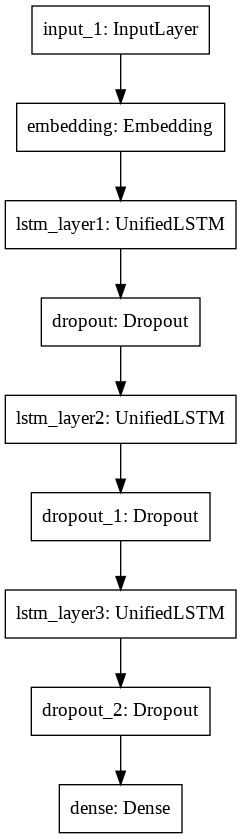

In [17]:
print(classifier.summary())
plot_model(classifier) # to_file='file_name.png'

## Training model

In [18]:
model = classifier.fit(
  X,
  Y,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Train on 53444 samples, validate on 13362 samples
Epoch 1/50
53444/53444 [==============================] - 128s 2ms/sample - loss: 1.7215 - accuracy: 0.3829 - val_loss: 1.7286 - val_accuracy: 0.3966
Epoch 2/50
53444/53444 [==============================] - 117s 2ms/sample - loss: 1.8057 - accuracy: 0.3308 - val_loss: 2.1426 - val_accuracy: 0.2634
Epoch 3/50
53444/53444 [==============================] - 117s 2ms/sample - loss: 1.7727 - accuracy: 0.3514 - val_loss: 1.9033 - val_accuracy: 0.3074
Epoch 4/50
53444/53444 [==============================] - 127s 2ms/sample - loss: 1.8107 - accuracy: 0.3279 - val_loss: 1.9869 - val_accuracy: 0.2441
Epoch 5/50
53444/53444 [==============================] - 120s 2ms/sample - loss: 1.8634 - accuracy: 0.2899 - val_loss: 1.9946 - val_accuracy: 0.2441
Epoch 6/50
53444/53444 [==============================] - 117s 2ms/sample - loss: 1.8626 - accuracy: 0.2897 - val_loss: 1.9882 - val_accuracy: 0.2443
Epoch 7/50
53444/53444 [==========================

## Evaluation

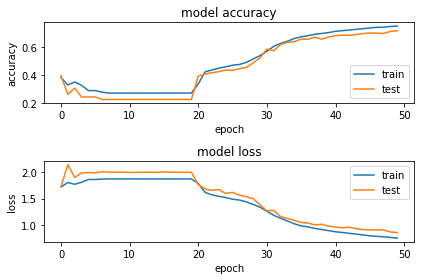

In [19]:
# Plot train and validation curves
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(model.history['accuracy'])
plt.plot(model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(2,1,2)
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()


In [20]:
# plot AUC over each label
Y_predict = classifier.predict(X)
auc = roc_auc_score(Y, Y_predict)
aucs = []
for j in range(n_labels):
    auc = roc_auc_score(Y[:,j], Y_predict[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.939239321548479
